**About Book Crossing Dataset**<br>

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

**Objective**

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches.

#### Execute the below cell to load the datasets

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
from contextlib import contextmanager
import sys, os

import Recommenders as Recommenders
import Evaluation as Evaluation

%config IPCompleter.greedy=True

## 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [3]:
ratings_df = pd.read_csv('ratings_Electronics.csv', error_bad_lines=False)
ratings_df.columns = ['user_id', 'item_id', 'score', 'timestamp']

In [4]:
ratings_df.head()

,user_id,item_id,score,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
# Checking for missing value 
print ("Count of null values in each feature:\n", ratings_df.isna().sum())

Count of null values in each feature:
 user_id      0
item_id      0
score        0
timestamp    0
dtype: int64


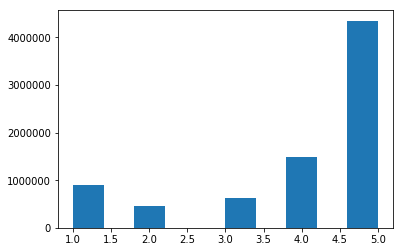

In [6]:
plt.hist(ratings_df.score)
plt.xlabel = 'Ratings'
plt.ylabel = 'Frequency'

In [7]:
ratings_summary_df = pd.DataFrame()
ratings_summary_df['mean_score'] = ratings_df.groupby('item_id')['score'].mean()
ratings_summary_df.head()

,mean_score
item_id,
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
0558835155,3.000000


In [8]:
ratings_summary_df['number_of_scores'] = ratings_df.groupby('item_id')['score'].count()
ratings_summary_df.head()

,mean_score,number_of_scores
item_id,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


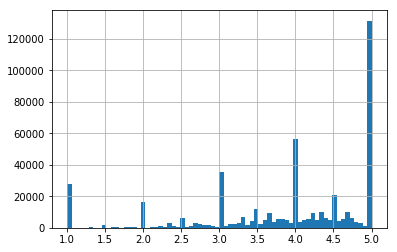

In [9]:
ratings_summary_df['mean_score'].hist(bins = 70) 

In [10]:
ratings_summary_df.sort_values('number_of_scores', ascending=False).tail(10)

,mean_score,number_of_scores
item_id,,
B004WL7YUC,4.0,1
B004WL8K4Q,5.0,1
B004WL8L6I,4.0,1
B004WL8LHW,1.0,1
B004WL90KY,5.0,1
B004WL91KI,4.0,1
B004WL9FK4,1.0,1
B004WL9Q2Q,4.0,1
B004WL9R8O,5.0,1


In [11]:
User_summary_df = pd.DataFrame()
User_summary_df['number_of_scores'] = ratings_df.groupby('user_id')['score'].count()
User_summary_df.head()

,number_of_scores
user_id,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [12]:
User_summary_df['number_of_scores'].unique()

array([  1,   2,   4,   3,   6,   7,   5,   8,  10,   9,  11,  12,  21,
        14,  19,  15,  13,  18,  17,  25, 116, 132,  20,  22,  16,  26,
        27,  24,  23,  32,  68,  71,  38,  36,  35,  30,  40,  34,  65,
        39,  33,  41,  31,  28,  57,  96,  80, 107,  46, 123,  77, 130,
        52,  29,  89,  37, 112,  67,  86,  66,  45,  75, 205,  58,  50,
       216,  43,  92,  54,  49,  64,  51, 252,  42,  72,  81,  44,  74,
        47,  53,  48,  62,  70, 104, 102,  60,  63, 157,  99,  56,  55,
        61, 261, 151,  94,  78, 119,  83,  73, 144, 177, 149, 106,  82,
        69, 108, 196,  76, 221, 197, 200, 155, 208, 207, 181, 160, 213,
        59, 103,  85,  98, 145, 218,  84, 101,  91, 100,  88, 114,  79,
        93, 131, 142, 380,  90,  95, 126, 110, 105,  97, 167, 227, 128,
       127, 247, 129, 220, 121,  87, 202, 109, 156, 111, 162, 240, 125,
       137, 150, 292, 270, 115, 226, 296, 311, 176, 170, 122, 117, 159,
       277, 238, 120, 253, 138, 171, 136, 314, 282, 236, 257, 20

(0, 10000)

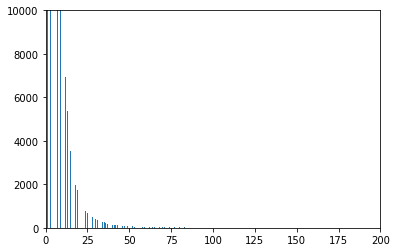

In [13]:
plt.hist(User_summary_df.number_of_scores, bins=2000)
plt.xlabel = 'Users: No. of scores'
plt.ylabel = 'Frequency'
plt.xlim(xmin=0, xmax = 200)
plt.ylim(ymin=0, ymax = 10000)

## 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [14]:
# Get the count of user who have rated more than 49 ratings
print (len(User_summary_df[User_summary_df.number_of_scores >= 50]))
print (len(User_summary_df[User_summary_df.number_of_scores < 50]))

1540
4200156


In [15]:
Users_df = User_summary_df[User_summary_df.number_of_scores >= 50]
Users_df.index

Index(['A100UD67AHFODS', 'A100WO06OQR8BQ', 'A105S56ODHGJEK', 'A105TOJ6LTVMBG',
       'A10AFVU66A79Y1', 'A10H24TDLK2VDP', 'A10NMELR4KX0J6', 'A10O7THJ2O20AG',
       'A10PEXB6XAQ5XF', 'A10X9ME6R66JDX',
       ...
       'AYOTEJ617O60K', 'AYP0YPLSP9ISM', 'AZ515FFZ7I2P7', 'AZ8XSDMIX04VJ',
       'AZAC8O310IK4E', 'AZBXKUH4AIW3X', 'AZCE11PSTCH1L', 'AZMY6E8B52L2T',
       'AZNUHQSHZHSUE', 'AZOK5STV85FBJ'],
      dtype='object', name='user_id', length=1540)

In [16]:
ratings_subset_df = ratings_df.loc[(ratings_df['user_id'].isin(Users_df.index))]
ratings_subset_df.shape

(125871, 4)

In [17]:
ratings_subset_df.drop('timestamp', axis = 1, inplace = True)

C:\Users\Iyyappan\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
ratings_subset_df.head()

,user_id,item_id,score
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


## 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [19]:
# Lets split the data to Train, Test
train_data, test_data = train_test_split(ratings_subset_df, test_size = 0.30, random_state=100)
print(train_data.head(5))

                user_id     item_id  score
5993537   ANW6EGY12V5XS  B007ZW43IQ    4.0
4459174  A1QVFHPY8418HC  B004T9Y0MW    5.0
2177399   ALDAF4VVLFRHP  B001NOG2T0    4.0
232286   A11YIHB6IW352W  B00007KDVI    5.0
7811982  A3PD8JD9L4WEII  B00JGSWU7S    5.0


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88109 entries, 5993537 to 2136394
Data columns (total 3 columns):
user_id    88109 non-null object
item_id    88109 non-null object
score      88109 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.7+ MB


In [21]:
# Get the unique user_id and have it in a list 
train_users = train_data['user_id'].unique()
train_items = train_data['item_id'].unique()
test_users = test_data['user_id'].unique()
test_items = test_data['item_id'].unique()

## 4. Build Popularity Recommender model.

In [22]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'item_id')

In [23]:
pm.recommend(train_users[5])

,user_id,item_id,score,Rank
2,A3H4S6YO9VNGDZ,0972683275,5.0,1.0
4,A3H4S6YO9VNGDZ,1400501520,5.0,2.0
5,A3H4S6YO9VNGDZ,1400501776,5.0,3.0
7,A3H4S6YO9VNGDZ,1400532655,5.0,4.0
11,A3H4S6YO9VNGDZ,3744295508,5.0,5.0
13,A3H4S6YO9VNGDZ,8862935307,5.0,6.0
17,A3H4S6YO9VNGDZ,9573212919,5.0,7.0
19,A3H4S6YO9VNGDZ,9800359788,5.0,8.0
22,A3H4S6YO9VNGDZ,9981739588,5.0,9.0
24,A3H4S6YO9VNGDZ,9984922626,5.0,10.0


In [24]:
pm.recommend(train_users[7])

,user_id,item_id,score,Rank
2,A27TN8D0CZ8LUY,0972683275,5.0,1.0
4,A27TN8D0CZ8LUY,1400501520,5.0,2.0
5,A27TN8D0CZ8LUY,1400501776,5.0,3.0
7,A27TN8D0CZ8LUY,1400532655,5.0,4.0
11,A27TN8D0CZ8LUY,3744295508,5.0,5.0
13,A27TN8D0CZ8LUY,8862935307,5.0,6.0
17,A27TN8D0CZ8LUY,9573212919,5.0,7.0
19,A27TN8D0CZ8LUY,9800359788,5.0,8.0
22,A27TN8D0CZ8LUY,9981739588,5.0,9.0
24,A27TN8D0CZ8LUY,9984922626,5.0,10.0


## 5. Build Collaborative Filtering model.

In [25]:
# We want the format of ratings matrix to be one row per user and one column per item. 
#we can pivot ratings_df to get that and call the new variable R_df.
R_df = train_data.pivot(index = 'user_id', columns ='item_id', values = 'score').fillna(0)
R_df.head

<bound method NDFrame.head of item_id         0594481813  0970407998  0972683275  1400501466  1400501520  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   
A10H24TDLK2VDP         0.0         0.0         0.0         0.0         0.0   
A10NMELR4KX0J6         0.0         0.0         0.0         0.0         0.0   
A10O7THJ2O20AG         0.0         0.0         0.0         0.0         0.0   
A10PEXB6XAQ5XF         0.0         0.0         0.0         0.0         0.0   
A10X9ME6R66JDX         0.0         0.0         0.0         0.0         0.0   
A10Y058K7B96C6         0.0        

In [26]:
RM_df=pd.DataFrame(R_df)

#declaring k,metric as global which can be changed by the user later
global k,metric
k=4
metric='cosine' #can be changed to 'correlation' for Pearson correlation similaries

In [27]:
#get cosine similarities for ratings matrix M; pairwise_distances returns the distances between ratings and hence
#similarities are obtained by subtracting distances from 1
cosine_sim = 1-pairwise_distances(RM_df, metric="cosine")

### Item Based Recommendation System

In [84]:
#This function finds k similar items given the item_id and ratings matrix M

def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.loc[item_id, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar items for item {1}:\n'.format(k,item_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;

        else:
            item = train_items[indices.flatten()[i]+1]
            print ('{0}: Item {1} :, with similarity of {2}'.format(i,item, similarities.flatten()[i]))


    return similarities,indices

In [85]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    
    for i in range(0, len(indices.flatten())):
        if train_items[indices.flatten()[i]+1] == item_id:
            continue;
        else:
            product = ratings.loc[user_id,train_items[indices.flatten()[i]]] * (similarities[i])
            #product = ratings.iloc[user_id,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [86]:
similarities,indices=findksimilaritems(train_items[2],RM_df)

4 most similar items for item B001NOG2T0:

0: Item B00KFAGCUM :, with similarity of 1.0
1: Item B00DW29TBY :, with similarity of 1.0
2: Item B0039UWW54 :, with similarity of 1.0
3: Item B0000TQ154 :, with similarity of 1.0
4: Item B0015LURY2 :, with similarity of 1.0


In [87]:
prediction = predict_itembased(train_users[2],train_items[2],RM_df)

4 most similar items for item B001NOG2T0:

0: Item B00KFAGCUM :, with similarity of 1.0
1: Item B00DW29TBY :, with similarity of 1.0
2: Item B0039UWW54 :, with similarity of 1.0
3: Item B0000TQ154 :, with similarity of 1.0
4: Item B0015LURY2 :, with similarity of 1.0

Predicted rating for user ALDAF4VVLFRHP -> item B001NOG2T0: 0


### User Based Recommendation System

In [32]:
#This function finds k similar users given the user_id and ratings matrix M
#Note that the similarities are same as obtained via using pairwise_distances
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.loc[user_id, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            user = train_users[indices.flatten()[i]+1]
            print ('{0}: User {1}, with similarity of {2}'.format(i, user, similarities.flatten()[i]))
            
    return similarities,indices

In [33]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.loc[user_id,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;
        else:             
            ratings_diff = ratings.loc[train_users[indices.flatten()[i]],item_id]-np.mean(ratings.loc[train_users[indices.flatten()[i]],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [34]:
similarities,indices = findksimilarusers(train_users[2],RM_df, metric='cosine')

4 most similar users for User ALDAF4VVLFRHP:

0: User A13WREJ05GMRA6, with similarity of 1.0
1: User A3HSDV9Y0TV5Z2, with similarity of 0.09422459728690291
2: User A680RUE1FDO8B, with similarity of 0.07907037171606279
3: User A27H61OHW44XA7, with similarity of 0.06427152170440897
4: User A16HXVNPU5TCGE, with similarity of 0.06397086568995336


In [35]:
predict_userbased(train_users[2],train_items[2],RM_df)

4 most similar users for User ALDAF4VVLFRHP:

0: User A13WREJ05GMRA6, with similarity of 1.0
1: User A3HSDV9Y0TV5Z2, with similarity of 0.09422459728690291
2: User A680RUE1FDO8B, with similarity of 0.07907037171606279
3: User A27H61OHW44XA7, with similarity of 0.06427152170440897
4: User A16HXVNPU5TCGE, with similarity of 0.06397086568995336

Predicted rating for user ALDAF4VVLFRHP -> item B001NOG2T0: 0


0

## 6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [36]:
#This is a quick way to temporarily suppress stdout in particular code section
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [52]:
#This is final function to evaluate the performance of selected recommendation approach and the metric used here is RMSE
#suppress_stdout function is used to suppress the print outputs of all the functions inside this function. 
#It will only print #RMSE values
def evaluateRS(ratings):
    n_users = 10 #ratings.shape[0]
    n_items = 10 #ratings.shape[1]
    prediction = np.zeros((n_users, n_items))
    prediction= pd.DataFrame(prediction)
    sub_ratings = np.zeros((n_users, n_items))
    sub_ratings = pd.DataFrame(sub_ratings)
    
    
    #User-based CF (cosine)
    with suppress_stdout():
        metric = 'cosine'
        for i in range(n_users):
            for j in range(n_items):
                prediction[i][j] = predict_userbased(train_users[i+1],train_items[j+1], ratings, metric)
                sub_ratings[i][j] = ratings.loc[train_users[i+1], train_items[j+1]]
    
    MSE = mean_squared_error(prediction, sub_ratings)
    RMSE = round(sqrt(MSE),3)
    print ("RMSE using user-based CF (cosine) approach is: {0}".format(RMSE))
    
    #item-based CF (cosine)
    with suppress_stdout():
        prediction = np.zeros((n_users, n_items))
        prediction= pd.DataFrame(prediction)
        sub_ratings = np.zeros((n_users, n_items))
        sub_ratings = pd.DataFrame(sub_ratings)
        for i in range(n_users):
            for j in range(n_items):
                prediction[i][j] = predict_itembased(train_users[i+1],train_items[j+1], ratings)
                sub_ratings[i][j] = ratings.loc[train_users[i+1], train_items[j+1]]

    MSE = mean_squared_error(prediction, sub_ratings)
    RMSE = round(sqrt(MSE),3)
    print ("RMSE using item-based CF (cosine) approach is: {0}".format(RMSE))

In [53]:
evaluateRS(R_df)

RMSE using user-based CF (cosine) approach is: 1.985
RMSE using item-based CF (cosine) approach is: 1.5


## 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [73]:
# Lets go on item based approach as we have got lesser RMSE score compared to user-based approach...
R_user = train_users[5]
R_item = RM_df.iloc[5].idxmax(axis=1)
predict_itembased('A3H4S6YO9VNGDZ','B000GHXTBO',RM_df)

4 most similar items for item B000GHXTBO:

0: Item B002OY80OI :, with similarity of 0.9999999999999998
1: Item B001CXT6NQ :, with similarity of 0.7071067811865475
2: Item B002LAIEFU :, with similarity of 0.7071067811865475
3: Item B00AD7PLJU :, with similarity of 0.7071067811865475
4: Item B004QBQAXU :, with similarity of 0.7071067811865475

Predicted rating for user A3H4S6YO9VNGDZ -> item B000GHXTBO: 0


0

In [59]:
RM_df.iloc[5].idxmax(axis=1)

'B0007RB280'

In [61]:
R_user

'A3H4S6YO9VNGDZ'

In [67]:
test = RM_df.iloc[567]
test[0].max()

0.0

In [63]:
RM_df.

item_id
0594481813    0.0
0970407998    0.0
0972683275    0.0
1400501466    0.0
1400501520    0.0
1400501776    0.0
1400532620    0.0
1400532655    0.0
140053271X    0.0
1400599997    0.0
1400698987    0.0
3744295508    0.0
7562434166    0.0
8862935307    0.0
8862936826    0.0
9043413585    0.0
9573212900    0.0
9573212919    0.0
9575871979    0.0
9800359788    0.0
9981719005    0.0
9981734241    0.0
9981739588    0.0
9983891212    0.0
9984922626    0.0
9984984362    0.0
9985511298    0.0
9985511476    0.0
9985525264    0.0
9985696999    0.0
             ... 
B00KW2W6B2    0.0
B00KW3OFG0    0.0
B00KWHMR6G    0.0
B00KWL62QI    0.0
B00KWMNDDM    0.0
B00KWPRSJY    0.0
B00KWWY1PQ    0.0
B00KXAFYZS    0.0
B00KXMN08E    0.0
B00KXUHX9S    0.0
B00KYA7CT8    0.0
B00KYMCJF8    0.0
B00L0YFJHY    0.0
B00L1I727Y    0.0
B00L1I80K2    0.0
B00L1NZTSS    0.0
B00L21HC7A    0.0
B00L2442H0    0.0
B00L26YDA4    0.0
B00L2P3TRS    0.0
B00L3YHF6O    0.0
B00L403O94    0.0
B00L5YZCCG    0.0
B00L8I6SFY    0.0
B0

In [71]:
user_data_R = train_data[train_data['user_id'] == 'A3H4S6YO9VNGDZ']
user_items_R = list(user_data_R['item_id'].unique())
user_items_R

train_data.ix[(train_data['item_id']=='B000GHXTBO') & (train_data['user_id'] == 'A3H4S6YO9VNGDZ')]

C:\Users\Iyyappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,user_id,item_id,score
971903,A3H4S6YO9VNGDZ,B000GHXTBO,5.0


In [88]:
similarities, indices=findksimilaritems('B000GHXTBO', R_df)

4 most similar items for item B000GHXTBO:

0: Item B002OY80OI :, with similarity of 0.9999999999999998
1: Item B001CXT6NQ :, with similarity of 0.7071067811865475
2: Item B002LAIEFU :, with similarity of 0.7071067811865475
3: Item B00AD7PLJU :, with similarity of 0.7071067811865475
4: Item B004QBQAXU :, with similarity of 0.7071067811865475


In [89]:
sum_wt = np.sum(similarities)-1 #2.828
product=1

In [90]:
sum_wt

2.82842712474619

In [ ]:
for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == 'B000GHXTBO':
            continue;
        else:
            product = ratings.iloc[2-1,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product     

In [91]:
indices

array([[ 7281, 19123, 37153, 23443, 17324]], dtype=int64)

In [101]:
R_df.iloc[2,indices.flatten()[3]]


0.0

In [94]:
similarities

array([1.        , 0.70710678, 0.70710678, 0.70710678, 0.70710678])

In [104]:
R_df.iloc[2,:]

item_id
0594481813    0.0
0970407998    0.0
0972683275    0.0
1400501466    0.0
1400501520    0.0
1400501776    0.0
1400532620    0.0
1400532655    0.0
140053271X    0.0
1400599997    0.0
1400698987    0.0
3744295508    0.0
7562434166    0.0
8862935307    0.0
8862936826    0.0
9043413585    0.0
9573212900    0.0
9573212919    0.0
9575871979    0.0
9800359788    0.0
9981719005    0.0
9981734241    0.0
9981739588    0.0
9983891212    0.0
9984922626    0.0
9984984362    0.0
9985511298    0.0
9985511476    0.0
9985525264    0.0
9985696999    0.0
             ... 
B00KW2W6B2    0.0
B00KW3OFG0    0.0
B00KWHMR6G    0.0
B00KWL62QI    0.0
B00KWMNDDM    0.0
B00KWPRSJY    0.0
B00KWWY1PQ    0.0
B00KXAFYZS    0.0
B00KXMN08E    0.0
B00KXUHX9S    0.0
B00KYA7CT8    0.0
B00KYMCJF8    0.0
B00L0YFJHY    0.0
B00L1I727Y    0.0
B00L1I80K2    0.0
B00L1NZTSS    0.0
B00L21HC7A    0.0
B00L2442H0    0.0
B00L26YDA4    0.0
B00L2P3TRS    0.0
B00L3YHF6O    0.0
B00L403O94    0.0
B00L5YZCCG    0.0
B00L8I6SFY    0.0
B0